# Spotify Playlist Generation Project - Model Code
AC209a Project Group 21 - Project D 
Team Members: Matthew Finney, Kaivalya Rawal, Royce Yap, David Zheng

<hr style="height:2pt">

## 1. Exploratory Data Analyis

See the submitted EDA notebook here: https://github.com/not-a-hot-dog/spotify_project/blob/master/eda/Exploratory_Data_Analysis.ipynb

<hr style="height:2pt">

## 2. Code used in Models

### 2.1 Import and Defined Functions Used Across Models

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
import pickle
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from scipy.sparse import save_npz
from scipy.sparse import load_npz
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from collections import Counter
from IPython.display import Image

np.random.seed(21)

In [2]:
# Helper function to get tracks for a pid
def get_tracks(pid, playlist_df):
    tracks = list(playlist_df.loc[playlist_df['pid'] == pid, 'track_uri'])
    return tracks

# Helper function to get tracks for a pid list
def select_playlists(df, pid_list, playlistfile = 'data/playlists.csv'):
    output = df[df['pid'].isin(pid_list)]    
    return output

# Helper function to get summary of track features from an array of tracks (e.g., get_tracks output)
def get_summary_features(track_uri_array, track_df):
    subset_track_df = track_df.loc[track_uri_array, :]
    features_mean = subset_track_df.describe().loc[['std'], :].reset_index(drop=True)
    features_mean.columns = [str(col) + '_mean' for col in features_mean.columns]
    features_std = subset_track_df.describe().loc[['std'], :].reset_index(drop=True)
    features_std.columns = [str(col) + '_std' for col in features_std.columns]
    artist_uri_freq = subset_track_df.artist_uri.value_counts(normalize=True)[0]
    if artist_uri_freq > 0.3:  # If the top artist doesn't have 30% of track in the playlist, ignore
        top_artist = pd.DataFrame([{'artist_uri_top': subset_track_df.artist_uri.value_counts(normalize=True).index[0],
                                    'artist_uri_freq': artist_uri_freq
                                    }]).reset_index(drop=True)
    else:
        top_artist = pd.DataFrame([{'artist_uri_top': np.NaN, 'artist_uri_freq': 0}])

    features = pd.concat([features_mean, features_std, top_artist], axis=1, sort=False)
    return features

# Helper function to get summary of track features, including artists
def val_test_features(track_uri_array, track_df, top_artists, pid=None):
    # Load list of dominating artists
    top_playlist_defining_artists = top_artists

    # Get summary features
    stub_playlist_features = get_summary_features(track_uri_array, track_df)

    artists_to_keep = stub_playlist_features.artist_uri_top.isin(top_playlist_defining_artists)
    stub_playlist_features.artist_uri_top = stub_playlist_features.artist_uri_top[artists_to_keep]
    stub_playlist_features.artist_uri_freq = stub_playlist_features.artist_uri_freq[artists_to_keep]
    stub_playlist_features.artist_uri_freq.fillna(0, inplace=True)
    stub_artist_dummies = pd.get_dummies(stub_playlist_features.artist_uri_top)
    top_artist_dummies = pd.DataFrame(columns=top_playlist_defining_artists)
    top_artist_dummies = pd.concat([top_artist_dummies, stub_artist_dummies], axis=0, sort=False)
    top_artist_dummies.fillna(0, inplace=True)
    stub_playlist_features = pd.concat([stub_playlist_features, top_artist_dummies], axis=1)
    stub_playlist_features.drop(['artist_uri_top'], axis=1, inplace=True)
    if pid:
        stub_playlist_features.index = [pid]

    return stub_playlist_features


def build_playlist_features(pid_list, playlist_df, track_df):
    output = pd.DataFrame()
    for pid in pid_list:
        output = output.append(get_summary_features(get_tracks(pid, playlist_df), track_df))
    output = output.set_index(pd.Index(pid_list))
    return output


def stub_withhold_split(pid: int, playlist_df: pd.DataFrame=None):
    if playlist_df is None: playlist_df = pd.read_csv('data/playlists.csv')
    tracks = get_tracks(pid, playlist_df)
    stub_tracks, withhold_tracks = train_test_split(tracks, random_state=21, test_size=0.3)
    return stub_tracks, withhold_tracks

def add_playlist(model, tracks):
    tracks = [track_to_index[j] for _, j in tracks.items()]
    for i, track1 in enumerate(tracks):
        for j in range(0,i):
            model[track1, tracks[j]] += 1
            
def test_on_playlist(model, tracks, n=5):
    tracks = [track_to_index[j] for _, j in tracks.items()]
    temp = np.zeros(num_unique_tracks) + 1
    ground_truth = []
    for i, track in enumerate(tracks):
        if i in selected_indices:
            temp += model[track]
        else:
            ground_truth.append(track)
    total = sum(temp)
    raw = sorted(list(enumerate(temp)), key= lambda x: x[1], reverse=True)
    tally = 0
    if n == '30%':
        n = len(ground_truth)
    elif n == '70%':
        n = int(len(ground_truth) * 7 / 3)
    for i in range(n):
        if raw[i][0] in ground_truth:
            tally += 1
    return tally / n

def get_ndcg_score(model, tracks, n=''):
    tracks = [track_to_index[j] for _, j in tracks.items()]
    temp = np.zeros(num_unique_tracks) + 1
    ground_truth = []
    for i, track in enumerate(tracks):
        if i in selected_indices:
            temp += model[track]
        else:
            ground_truth.append(track)
    total = sum(temp)
    raw = sorted(list(enumerate(temp)), key= lambda x: x[1], reverse=True)
    if n == '30%':
        n = len(ground_truth)
    elif n == '70%':
        n = int(len(ground_truth) * 7 / 3)
    preds = []
    for pred in raw[:n]:
        preds.append(pred[0])
    return ndcg(ground_truth, preds)

def make_recommendation(withheld_df, model_knn, playlist_id, n_neighbors, n_recommendations):
    
    no_withheld_songs = len(withheld_df[withheld_df.pid == pid].track_uri)
    
    #Get the indices and list of playlists of the k nearest neighbors to the playlist
    dist, indice = model_knn.kneighbors(np.array(co_mat.loc[playlist_id]).reshape(1, -1), n_neighbors = n_neighbors)
    rec_playlists = co_mat.index[indice[0]]
    
    #For all songs in the playlist, assign a frequency rating to them
    song_freq_dict = {}
    
    for playlist in rec_playlists:
        playlist_songs = combined_df[combined_df['pid']==playlist]["track_uri"]

        for song in playlist_songs:
            if song_freq_dict.get(song) is None:
                song_freq_dict[song] = 1
            else:
                song_freq_dict[song] += 1
    
       
    #Select the top n number of songs in the list of songs across recommended playlists
    k = Counter(song_freq_dict) 

    # Finding n highest values and returning song titles
    top_songs = [i[0] for i in k.most_common(n_recommendations)]    
    
    return top_songs

### 2.2 Model Evaluation Metrics

In [3]:
# Model Evaluation Metrics, adapted from https://recsys-challenge.spotify.com/rules
def r_precision(predicted_tracks: np.ndarray, withhold_tracks: np.ndarray):
    mask = np.isin(withhold_tracks, predicted_tracks) # Give credit for predicting a track that's in withhold twice!
    r_precision_score = np.sum(mask)/len(withhold_tracks)
    return r_precision_score


def hit_rate(predicted_tracks: np.ndarray, withhold_tracks: np.ndarray):
    mask = np.isin(predicted_tracks, withhold_tracks)
    hit_rate_score = np.sum(mask)/len(predicted_tracks)
    return hit_rate_score


def dcg(withhold_tracks, predicted_tracks):
    try:
        mask = np.isin(predicted_tracks, withhold_tracks)
        score = np.sum(mask[0]) + np.sum(mask[1:] / np.log2(np.arange(2, mask.size + 1)))
    except Exception:
        score = np.NaN
    return score


def idcg(withhold_tracks):
    n_withheld = len(withhold_tracks)
    ones = np.ones(n_withheld-1)
    score = 1 + np.sum(ones / np.log2(np.arange(2, n_withheld + 1)))
    return max(score, 1)


def ndcg(withhold_tracks, predicted_tracks):
    dcg_score = dcg(withhold_tracks=withhold_tracks, predicted_tracks=predicted_tracks)
    idcg_score = idcg(withhold_tracks)
    ndcg_score = dcg_score/idcg_score
    return ndcg_score

<hr style="height:2pt">

## 2.3 Naive Bayes Model

### 2.3.1 Data Preparation

In [4]:
playlists = pd.read_csv('./data/playlists.csv')
train_pids = pd.read_csv('./data/train_pids.csv').to_numpy().reshape(1,-1)[0]
val_pids = pd.read_csv('./data/val_pids.csv').to_numpy().reshape(1,-1)[0]
test_pids = pd.read_csv('./data/test_pids.csv').to_numpy().reshape(1,-1)[0]

In [5]:
index_to_track = {}
track_to_index = {}
for index, track in enumerate(np.unique(playlists.track_uri)):
    index_to_track[index] = track
    track_to_index[track] = index
num_unique_tracks = len(track_to_index)

In [6]:
selected_indices = []
unselected_indices = []
max_tracks_in_playlist = 10000
for i, j in enumerate(np.random.random(max_tracks_in_playlist)):
    if j < 0.7:
        selected_indices.append(i)
    else:
        unselected_indices.append(i)

### 2.3.2 Model Training

In [7]:
model = np.zeros((num_unique_tracks,num_unique_tracks))
for i, pid in enumerate(train_pids):
    add_playlist(model, playlists.loc[playlists['pid'] == pid]['track_uri'])
#     print(i)
    if i % 1000 == 1:
        print('\n', i)
    elif i % 20 == 1:
        print('.', end='')


 1
.................................................
 1001
.................................................
 2001
.................................................
 3001
.................................................
 4001
.................................................
 5001
.................................................
 6001
.................................................
 7001
.................................................
 8001
.................................................
 9001
.................................................
 10001
.................................................
 11001
.................................................
 12001
.................................................
 13001
....

In [8]:
# with open('naive-model.npy', 'wb') as f:
#     np.save(f, model)

# # with open('naive-model.npz', 'wb') as f:
# #     save_npz(f, coo_matrix(model))

### 2.3.3 Evaluating Model Performance

In [9]:
result = []
for i, pid in enumerate(test_pids):
    result.append(test_on_playlist(model, playlists.loc[playlists['pid'] == pid]['track_uri'], n=10))

In [10]:
ndcg_30pc = []
for i, pid in enumerate(test_pids):
    ndcg_30pc.append(get_ndcg_score(model, playlists.loc[playlists['pid'] == pid]['track_uri'], n='30%'))

In [11]:
ndcg_70pc = []
for i, pid in enumerate(test_pids):
    ndcg_70pc.append(get_ndcg_score(model, playlists.loc[playlists['pid'] == pid]['track_uri'], n='70%'))

In [12]:
result_30pc = []
for i, pid in enumerate(test_pids):
    result_30pc.append(test_on_playlist(model, playlists.loc[playlists['pid'] == pid]['track_uri'], n='30%'))

result_70pc = []
for i, pid in enumerate(test_pids):
    result_70pc.append(test_on_playlist(model, playlists.loc[playlists['pid'] == pid]['track_uri'], n='70%'))

In [13]:
plot_scores = np.vstack([result, result_30pc, result_70pc, ndcg_30pc, ndcg_70pc]).T

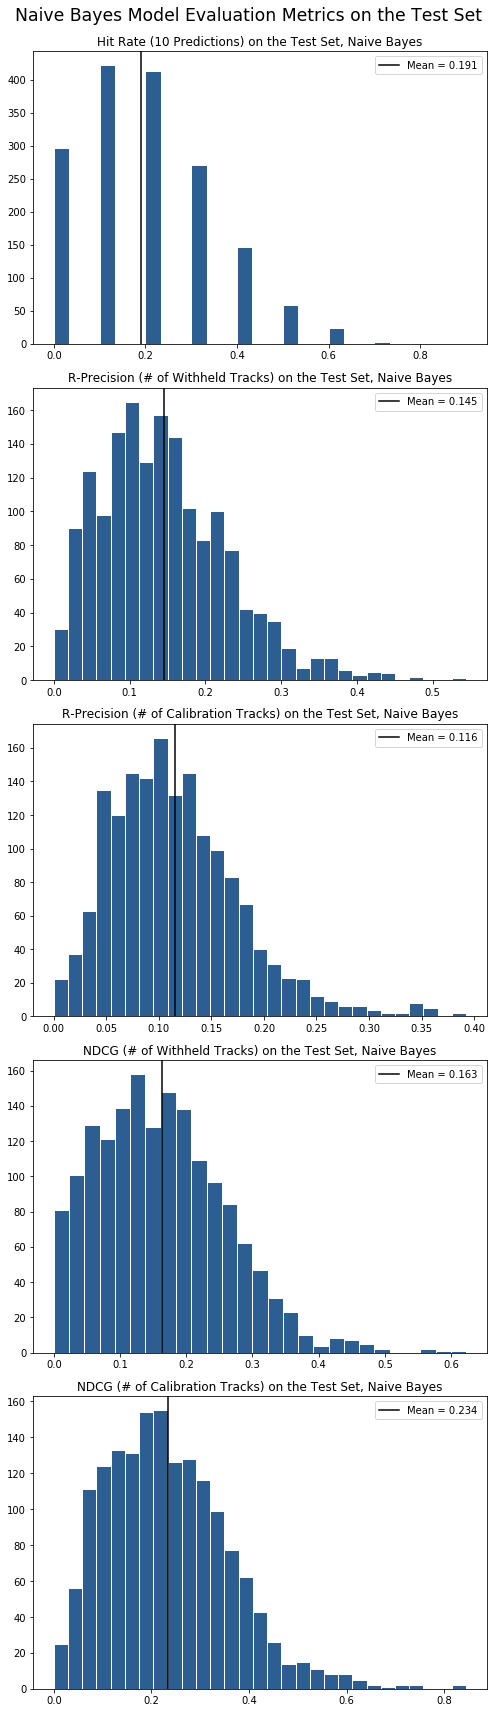

In [14]:
score_names = ['Hit Rate (10 Predictions)','R-Precision (# of Withheld Tracks)','R-Precision (# of Calibration Tracks)','NDCG (# of Withheld Tracks)','NDCG (# of Calibration Tracks)']
model_name = 'Naive Bayes'
set_name = 'Test'

# Plot each score
fig, ax = plt.subplots(5,1, figsize=(7,25))
for i in range(plot_scores.shape[1]):
    scores = plot_scores[:,i]
    sns.distplot(scores, kde=False, rug=False, hist_kws={'rwidth':1,'edgecolor':'white', 'alpha': 1}, ax=ax[i], color="#2C5E92")
    ax[i].axvline(np.mean(scores), label='Mean = {}'.format(round(np.mean(scores), 3)), color='k')
    ax[i].legend()
    ax[i].set_title(f'{score_names[i]} on the {set_name} Set, {model_name}')
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle(f'{model_name} Model Evaluation Metrics on the {set_name} Set', size='xx-large')
plt.show()

<hr style="height:2pt">

## 2.4 K Means Clustering / K Centroid Model

### 2.4.1 Data Pre-Processing

### 2.4.2 K-Means Clustering

In [15]:
# Get the train features dataframe
playlist_features = pd.read_csv('data/playlist_features_with_artists_train.csv', index_col=0, header=0)
playlist_list = playlist_features.index.values

# Set desired number of clusters
n_clusters = int(np.sqrt(len(playlist_features)))

print('Making clusters')
# Make clusters
kmeans = KMeans(n_clusters=n_clusters, verbose=0, algorithm='auto')
kmeans.fit(playlist_features)


print('Saving clusters')
# Saving the clusters
pickle.dump(kmeans, open('model/kmeans_cluster_train.pkl', 'wb'))
cluster_centers = kmeans.cluster_centers_
np.savetxt('model/kmeans_cluster_centers_train.csv', cluster_centers, delimiter=',')

# Saving the cluster label for each playlist in train (e.g., for track frequency table by cluster)
cluster_labels = kmeans.labels_
playlist_cluster_labels = np.column_stack((playlist_list, cluster_labels))
np.savetxt('model/playlist_cluster_labels_train.csv', playlist_cluster_labels, delimiter=',', fmt='%i')


Making clusters
Saving clusters


### 2.4.3 Specification of the Nearest Centroid Model

In [16]:
cluster_centers = np.genfromtxt('model/kmeans_cluster_centers_train.csv', skip_header=0, delimiter=',')

# Fit the neighbors classifier
nearest_cluster = NearestNeighbors(n_neighbors=1)
nearest_cluster.fit(cluster_centers)
pickle.dump(nearest_cluster, open('model/nearest_cluster_train.pkl', 'wb'))

### 2.4.4 Development of Track Frequency Tables

In [17]:
print('Read in cluster labels')
playlist_cluster_labels = pd.read_csv('model/playlist_cluster_labels_train.csv', header=None, delimiter=',', dtype=int,
                                      names=['pid', 'cluster_id'])
clusters = np.unique(playlist_cluster_labels.cluster_id)

print('Read in the playlist dataframe')
playlistfile = 'data/playlists.csv'
playlist_df = pd.read_csv(playlistfile, header=0, usecols=('pid', 'track_uri'))

frequency_dict = {}

print('Loop through the clusters and return the frequency each track for each cluster')
for cluster in clusters:
    cluster_pids = playlist_cluster_labels.pid[playlist_cluster_labels.cluster_id == cluster]
    tracks = playlist_df.track_uri[playlist_df.pid.isin(cluster_pids)]
    track_frequencies = tracks.value_counts(normalize=True)
    frequency_dict[cluster] = track_frequencies

pickle.dump(frequency_dict, open('model/cluster_track_frequencies.pkl', 'wb'))

Read in cluster labels
Read in the playlist dataframe
Loop through the clusters and return the frequency each track for each cluster


### 2.4.5 Functions that Apply the K-Centroid Model to Return Predictions

In [18]:
def predict_cluster(model, track_uri_array=None, track_df=None, top_artists=None, pid: int = None,
                    features_df: pd.DataFrame = None, return_features=False):
    """
    :return: the predicted cluster id for the array of tracks provided
    """
    # Load nearest cluster model
    nearest_cluster = model

    if pid:
        stub_playlist_features = np.array(features_df.loc[pid, :]).reshape(1, -1)
        dist, cluster_id = nearest_cluster.kneighbors(stub_playlist_features)
        if return_features:
            return int(cluster_id), stub_playlist_features
        else:
            return int(cluster_id)

    else:

        # Load list of dominating artists
        top_playlist_defining_artists = top_artists

        # Get summary features
        stub_playlist_features = get_summary_features(track_uri_array, track_df)

        artists_to_keep = stub_playlist_features.artist_uri_top.isin(top_playlist_defining_artists)
        stub_playlist_features.artist_uri_top = stub_playlist_features.artist_uri_top[artists_to_keep]
        stub_playlist_features.artist_uri_freq = stub_playlist_features.artist_uri_freq[artists_to_keep]
        stub_playlist_features.artist_uri_freq.fillna(0, inplace=True)
        stub_artist_dummies = pd.get_dummies(stub_playlist_features.artist_uri_top)
        top_artist_dummies = pd.DataFrame(columns=top_playlist_defining_artists)
        top_artist_dummies = pd.concat([top_artist_dummies, stub_artist_dummies], axis=0, sort=False)
        top_artist_dummies.fillna(0, inplace=True)
        stub_playlist_features = pd.concat([stub_playlist_features, top_artist_dummies], axis=1)
        stub_playlist_features.drop(['artist_uri_top'], axis=1, inplace=True)

        dist, cluster_id = nearest_cluster.kneighbors(stub_playlist_features)
        if return_features:
            return int(cluster_id), stub_playlist_features
        else:
            return int(cluster_id)


def predict_tracks(track_uri_array=None, n_tracks='max', frequency_dict: dict = None, pid: int = None,
                   features_df: pd.DataFrame = None,
                   playlist_df: pd.DataFrame = None, track_df: pd.DataFrame = None, model=None,
                   top_artists: np.ndarray = None, return_features=False):
    """
    :param features_df:
    :param return_features:
    :param top_artists:
    :param model:
    :param track_df:
    :param playlist_df:
    :param frequency_dict:
    :param track_uri_array: an array of tracks
    :param n_tracks: The number of tracks to predict
    :return: an array of predicted tracks and probabilities of length n_songs
    """

    # Load nearest cluster model
    if model is None: model = pickle.load(open('model/nearest_cluster_train.pkl', 'rb'))
    if playlist_df is None: playlist_df = pd.read_csv('data/playlists.csv')
    if track_df is None: track_df = pd.read_csv('data/songs_100000_feat_cleaned.csv', index_col='track_uri')
    if top_artists is None: top_artists = np.genfromtxt('data/top_playlist_defining_artists_train.csv', usecols=0,
                                                        skip_header=0, delimiter=',', dtype=str)
    if frequency_dict is None: frequency_dict = pickle.load(open('model/cluster_track_frequencies.pkl', 'rb'))

    # Predict the cluster given the provided track_uris
    if return_features:
        predicted_cluster, features = predict_cluster(track_uri_array=track_uri_array, track_df=track_df, model=model,
                                                      top_artists=top_artists,
                                                      return_features=return_features, pid=pid, features_df=features_df)
    else:
        predicted_cluster = predict_cluster(track_uri_array=track_uri_array, track_df=track_df, model=model,
                                            top_artists=top_artists, pid=pid, features_df=features_df)

    # Find the frequency with which tracks appear in that cluster
    track_frequencies = frequency_dict[predicted_cluster]

    # Exclude tracks which are already in the input track_uri_array
    excluded_recommendations = track_frequencies.index.isin(track_uri_array)
    track_frequencies = track_frequencies[~excluded_recommendations]

    # Return n_tracks predictions
    track_predictions = track_frequencies.reset_index()
    track_predictions.columns = ['track_uri', 'probability']
    if n_tracks == 'max':
        n_tracks = len(track_predictions)
    track_predictions = track_predictions.nlargest(n_tracks, 'probability')

    if return_features:
        return predicted_cluster, track_predictions, features
    else:
        return predicted_cluster, track_predictions

### 2.4.6 Model Performance - Evaluation on the Test Set

In [19]:
# Make predictions
start_time = time.time(), time.ctime()
print(f'Start time: {start_time[1]}')

# Build df of playlists to classify in clusters

# Import data to memory so it is not loaded from disk for every loop iteration
model = pickle.load(open('model/nearest_cluster_train.pkl', 'rb'))
playlist_df = pd.read_csv('data/playlists.csv')
track_df = pd.read_csv('data/songs_100000_feat_cleaned.csv', index_col='track_uri')
top_artists = np.genfromtxt('data/top_playlist_defining_artists_train.csv', usecols=0,
                            skip_header=0, delimiter=',', dtype=str)
frequency_dict = pickle.load(open('model/cluster_track_frequencies.pkl', 'rb'))
features_df = pd.read_csv('data/playlist_features_with_artists_test.csv', index_col=0)

# Create output vessels
test_clusters = pd.DataFrame(index=pd.Index(test_pids), columns=['cluster_id', 'n_predictions'])
test_predictions = {}
test_withheld = {}
errors = 0

# Loop through pids and make predictions
for idx, pid in enumerate(test_pids):
    try:
        stub_tracks, withhold_tracks = stub_withhold_split(pid)
        cluster, predictions = predict_tracks(track_uri_array=stub_tracks, n_tracks=len(stub_tracks),
                                              frequency_dict=frequency_dict,
                                              playlist_df=playlist_df, track_df=track_df, model=model,
                                              top_artists=top_artists, pid=pid, features_df=features_df)
        test_predictions[pid] = predictions
        test_withheld[pid] = withhold_tracks
        test_clusters.at[pid, :] = cluster, predictions.shape[0]
    except Exception as e:
        print(f'Error for pid {pid}: \n{e}')
        test_clusters.at[pid, :] = np.NaN, np.NaN
        errors += 1

    if (idx + 1) % 100 == 0:
        print(f'[{time.ctime()}] Progress {idx + 1} playlists and {errors} errors')

end_time = time.time(), time.ctime()
time_elapsed = end_time[0] - start_time[0]
time_elapsed = time.strftime('%H:%M:%S', time.gmtime(time_elapsed))
print(f'End time: {end_time[1]}, Time elapsed: {time_elapsed}')

# Save output
test_clusters.to_csv('model/k_means_clusters_test.csv', sep=',', index=True)
pickle.dump(test_predictions, open('model/k_means_predictions_test.pkl', 'wb'))
pickle.dump(test_withheld, open('model/k_means_withheld_test.pkl', 'wb'))

Start time: Sun Dec  8 21:00:13 2019
[Sun Dec  8 21:02:55 2019] Progress 100 playlists and 0 errors
[Sun Dec  8 21:05:33 2019] Progress 200 playlists and 0 errors
[Sun Dec  8 21:08:11 2019] Progress 300 playlists and 0 errors
[Sun Dec  8 21:10:49 2019] Progress 400 playlists and 0 errors
[Sun Dec  8 21:13:29 2019] Progress 500 playlists and 0 errors
[Sun Dec  8 21:16:08 2019] Progress 600 playlists and 0 errors
[Sun Dec  8 21:18:47 2019] Progress 700 playlists and 0 errors
[Sun Dec  8 21:21:26 2019] Progress 800 playlists and 0 errors
[Sun Dec  8 21:24:09 2019] Progress 900 playlists and 0 errors
[Sun Dec  8 21:26:53 2019] Progress 1000 playlists and 0 errors
[Sun Dec  8 21:29:36 2019] Progress 1100 playlists and 0 errors
[Sun Dec  8 21:32:21 2019] Progress 1200 playlists and 0 errors
[Sun Dec  8 21:35:12 2019] Progress 1300 playlists and 0 errors
[Sun Dec  8 21:37:51 2019] Progress 1400 playlists and 0 errors
[Sun Dec  8 21:40:30 2019] Progress 1500 playlists and 0 errors
[Sun Dec  8 

In [20]:
# Load predictions for the test set and evaluate
test_clusters = np.genfromtxt('model/k_means_clusters_test.csv', skip_header=1, dtype=int, delimiter=',', usecols=[0, 1])
test_predictions = pickle.load(open('model/k_means_predictions_test.pkl', 'rb'))
test_withheld = pickle.load(open('model/k_means_withheld_test.pkl', 'rb'))

# Create output vessel
test_scores = np.zeros((test_clusters.shape[0], 7))

for idx, (pid, cluster_id) in enumerate(test_clusters):
    # Load list of withheld tracks
    withhold_tracks = test_withheld[pid]

    # Load list of predicted tracks
    predictions = test_predictions[pid].track_uri

    # Figure out how many tracks to use in the scoring (and don't score for more than predicted)
    n_predictions = len(predictions)
    n_10 = min(n_predictions, 10)
    n_withheld = min(n_predictions, len(withhold_tracks))
    n_7withheld_over_3 = min(n_predictions, int(n_withheld * 7 / 3))

    predictions_10 = predictions[:n_10]
    predictions_n_withheld = predictions[:n_withheld]
    predictions_7withheld_over_3 = predictions[:n_7withheld_over_3]

    # Score the predictions!
    hit_rate_10 = hit_rate(withhold_tracks=withhold_tracks, predicted_tracks=predictions_10)
    rps_withheld = r_precision(withhold_tracks=withhold_tracks, predicted_tracks=predictions_n_withheld)
    rps_7withheld_over_3 = r_precision(withhold_tracks=withhold_tracks, predicted_tracks=predictions_7withheld_over_3)
    ndcg_withheld = ndcg(withhold_tracks=withhold_tracks, predicted_tracks=predictions_n_withheld)
    ndcg_7withheld_over_3 = ndcg(withhold_tracks=withhold_tracks, predicted_tracks=predictions_7withheld_over_3)

    # Write to array
    test_scores[
        idx] = pid, cluster_id, hit_rate_10, rps_withheld, rps_7withheld_over_3, ndcg_withheld, ndcg_7withheld_over_3

np.savetxt("model/k9_scores_test.csv", test_scores, delimiter=",",
           header='pid,cluster_id,hit_rate_10,rps_withheld,rps_7withheld_over_3,ndcg_withheld,ndcg_7withheld_over_3')

### 2.4.7 Evaluation Plots

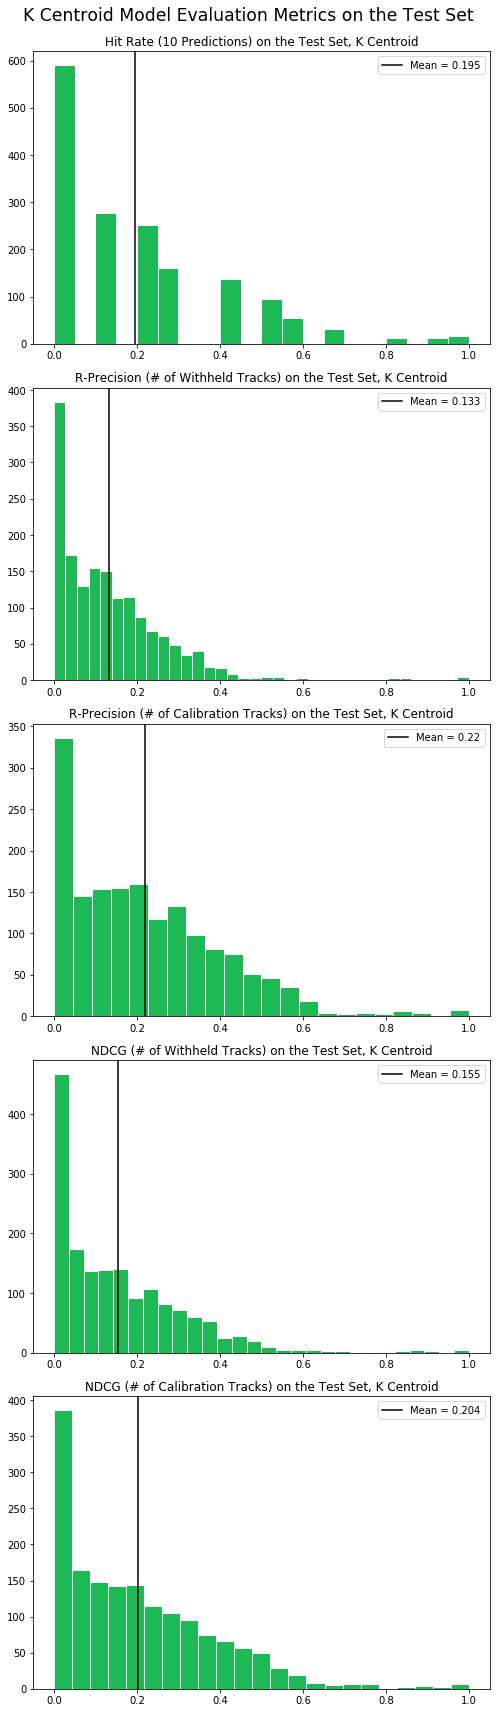

In [21]:
# Load score data
test_scores = np.genfromtxt('model/k9_scores_test.csv', skip_header=0, delimiter=',', dtype=float)
plot_scores = test_scores[:,2:]
score_names = ['Hit Rate (10 Predictions)','R-Precision (# of Withheld Tracks)','R-Precision (# of Calibration Tracks)','NDCG (# of Withheld Tracks)','NDCG (# of Calibration Tracks)']
model_name = 'K Centroid'
set_name = 'Test'

# Plot each score
fig, ax = plt.subplots(5,1, figsize=(7,25))
for i in range(plot_scores.shape[1]):
    scores = plot_scores[:,i]
    sns.distplot(scores, kde=False, rug=False, hist_kws={'rwidth':1,'edgecolor':'white', 'alpha': 1}, ax=ax[i], color="#1db954")
    ax[i].axvline(np.mean(scores), label='Mean = {}'.format(round(np.mean(scores), 3)), color='k')
    ax[i].legend()
    ax[i].set_title(f'{score_names[i]} on the {set_name} Set, {model_name}')
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle(f'{model_name} Model Evaluation Metrics on the {set_name} Set', size='xx-large')
plt.show()

<hr style="height:2pt">

## 2.5 k-NN User-Based Collaborative Filtering model 

### 2.5.1 Preparation of Data

In [22]:
#Storing playlist file as dataframe (done in earlier section)
# playlistfile = 'playlists.csv'
# playlists = pd.read_csv(playlistfile)

#Retrieving information on track features
trackfile = 'data/songs_100000_feat_cleaned.csv'
track_features = pd.read_csv(trackfile)

track_features = track_features[['track_uri', 'track_name','artist_name']] 

#Obtain train set
train_pids = np.genfromtxt('data/train_pids.csv', skip_header=1, dtype=int)
train_set = select_playlists(playlists, train_pids)

# Obtain test set and split into calibration and withheld
test_pids = np.genfromtxt('data/test_pids.csv', skip_header=1, dtype=int)
test_set = select_playlists(playlists, test_pids)
calibration, withheld = train_test_split(test_set, test_size=0.3, random_state=21, stratify = test_set['pid'])

# Checking to ensure that a significant proportion of songs in withheld list is in train set
intersection = withheld[withheld['track_uri'].isin(train_set.track_uri)]
print("Songs in withheld playlist that is in train_set:", len(intersection))
print ("Total songs in withheld playlist:", len(list(withheld.track_uri)))
print ("Percentage of coverage of songs:", len(intersection)/len(list(withheld.track_uri)))

#Appending calibration set to the train set, so that playlists in calibration set are part of the matrix
combined_df = train_set.append(calibration)

#Filtering the playlist information to only keep track_uri and pid information
df_matrix = combined_df[['track_uri','pid']]

#Count the number of times a track appears within a playlist and keep only the tracks that appear less than 10 times
# I.e. If a song appears more than 10 times, the playlist would not be defined as a well-curated playlist 
df_matrix['Count']=df_matrix.groupby(['pid','track_uri'])['track_uri'].transform('count')
df_matrix = df_matrix.drop_duplicates()
df_matrix=df_matrix[df_matrix['Count']<=10]

Songs in withheld playlist that is in train_set: 66915
Total songs in withheld playlist: 67463
Percentage of coverage of songs: 0.99187702888991


C:\Users\royce\Anaconda3\envs\cs109a\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### 2.5.2 Training the model

In [23]:
# Create Binary Sparse Matrix
co_mat = pd.crosstab(df_matrix.pid, df_matrix.track_uri)
co_mat = co_mat.clip(upper=1)
co_mat_sparse = csr_matrix(co_mat)

# Train kNN model
model_knn = NearestNeighbors(metric='cosine', algorithm='auto', n_neighbors=20, n_jobs=-1)

# Fit the sparse covariance matrix
model_knn.fit(co_mat_sparse)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [24]:
##Example of running make_recommendations on given playlist
n_neighbors = 50
pid = 176769
withheld_set = withheld[withheld.pid == pid].track_uri

pred_songs = make_recommendation(withheld, model_knn, pid, n_neighbors, 50)
track_features[track_features['track_uri'].isin(pred_songs)]['track_name']
df = pd.DataFrame(track_features[track_features['track_uri'].isin(pred_songs)]['track_name'])

### 2.5.3 Evaluating the model

In [25]:
# Predicting songs based on n_neighbors, n_recommendations values 
n_neighbors = 50
recc_no_k = [1, 7/3]
rps_list = []
ndcgs_list = []
all_values = {}

for recc_no in recc_no_k: 
    r_precision_scores = []
    ndcgs = []
    total_withheld = withheld['pid'].nunique()

    #Loop through all unique playlists in test set to identify predicted songs
    for index, pid in enumerate(withheld['pid'].drop_duplicates()): 
#         print (round(recc_no,2) , "Playlist No: ", index + 1, "/", total_withheld)
        withheld_set = withheld[withheld.pid == pid].track_uri
        no_recommendations = int(len(withheld_set) * recc_no)
        pred_songs = make_recommendation(withheld, model_knn, pid, n_neighbors, no_recommendations)
        
#         print("Predicted songs\n", track_features[track_features['track_uri'].isin(pred_songs)]['track_name'])
#         print("Withheld songs\n", track_features[track_features['track_uri'].isin(withheld_set)]['track_name'])
#         print("Overlapping songs\n", track_features[track_features['track_uri'].isin(withheld_set)&track_features['track_uri'].isin(pred_songs)]['track_name'])

        #Calculate R precision score for playlist and append it to r_precision_scores list
        rps = r_precision(list(pred_songs), withheld_set)
        r_precision_scores.append(rps)

        #Calculate NDCG for playlist and append it to ndcgs list
        ndcg_playlist = ndcg(withheld_set, pred_songs)
        ndcgs.append(ndcg_playlist)

#         print(f'Playlist {pid}: The R precision score is {rps}')
#         print(f'Playlist {pid}: The NDCGS metric is {ndcg_playlist}')
    
    all_values[f'RPS for {str(recc_no)} x k predictions'] = r_precision_scores
    all_values[f'NDCGS for {str(recc_no)} x k predictions'] = ndcgs
    rps_list.append(np.mean(r_precision_scores))
    ndcgs_list.append(np.mean(ndcgs))

In [26]:
# Predicting 10 songs using hit rate
# Predicting songs based on n_neighbors, n_recommendations values 
#Loop through all unique playlists in test set to identify predicted songs

hit_rate_tracking = []

for index, pid in enumerate(withheld['pid'].drop_duplicates()): 
#     print ("[Hit Rate] Playlist No: ", index + 1, "/", total_withheld)
    withheld_set = withheld[withheld.pid == pid].track_uri
    no_recommendations = len(withheld_set) * recc_no
    pred_songs = make_recommendation(withheld, model_knn, pid, n_neighbors, 10)

#     print("Predicted songs\n", track_features[track_features['track_uri'].isin(pred_songs)]['track_name'])
#     print("Withheld songs\n", track_features[track_features['track_uri'].isin(withheld_set)]['track_name'])
#     print("Overlapping songs\n", track_features[track_features['track_uri'].isin(withheld_set)&track_features['track_uri'].isin(pred_songs)]['track_name'])

    #Calculate R precision score for playlist and append it to r_precision_scores list
    hits = hit_rate(list(pred_songs), withheld_set)
    hit_rate_tracking.append(hits)

#     print(f'Playlist {pid}: The hit rate is {hits}')

In [27]:
rps_1k = all_values['RPS for 1 x k predictions']
rps_2k = all_values['RPS for 2.3333333333333335 x k predictions']
ncdgs_1k = all_values['NDCGS for 1 x k predictions']
ncdgs_2k = all_values['NDCGS for 2.3333333333333335 x k predictions']
plot_scores = np.c_[hit_rate_tracking, rps_1k, rps_2k, ncdgs_1k, ncdgs_2k]

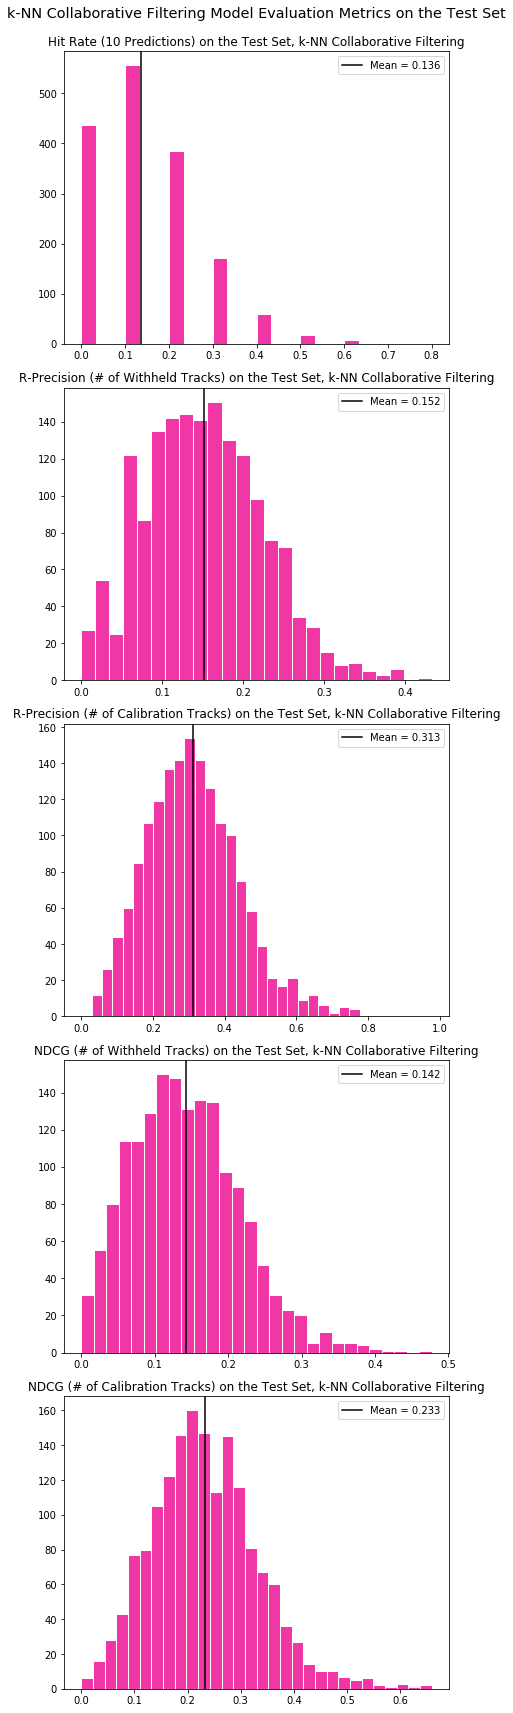

In [28]:
# Load score data
score_names = ['Hit Rate (10 Predictions)','R-Precision (# of Withheld Tracks)','R-Precision (# of Calibration Tracks)','NDCG (# of Withheld Tracks)','NDCG (# of Calibration Tracks)']
model_name = 'k-NN Collaborative Filtering'
set_name = 'Test'# Plot each score
fig, ax = plt.subplots(5,1, figsize=(7,25))
for i in range(plot_scores.shape[1]):
    scores = plot_scores[:,i]
    sns.distplot(scores, kde=False, rug=False, hist_kws={'rwidth':1,'edgecolor':'white', 'alpha': 1}, ax=ax[i], color="#F037A5")
    ax[i].axvline(np.mean(scores), label='Mean = {}'.format(round(np.mean(scores), 3)), color='k')
    ax[i].legend()
    ax[i].set_title(f'{score_names[i]} on the {set_name} Set, {model_name}')
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle(f'{model_name} Model Evaluation Metrics on the {set_name} Set', size='x-large')
plt.show()